In [1]:
R.version

               _                           
platform       x86_64-apple-darwin17.0     
arch           x86_64                      
os             darwin17.0                  
system         x86_64, darwin17.0          
status                                     
major          4                           
minor          0.5                         
year           2021                        
month          03                          
day            31                          
svn rev        80133                       
language       R                           
version.string R version 4.0.5 (2021-03-31)
nickname       Shake and Throw             

In [2]:
library(qiime2R)
library(tidyr)
library(tibble)
library(ggplot2)
library(vegan)
library(microbiome)
library(phyloseq)
library(dplyr)

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-7

Loading required package: phyloseq


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2020 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:vegan’:

    diversity


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
#rm(, large_list, large_vector, temp_variables)

In [3]:
# Read in the 16S qza files and clean them up for phyloseq
ASVtable_16S <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/QiimeOutPut/2022_Process/tableV_BacArc_99_SCTLD.qza")
ASVtable_16S <- ASVtable_16S$data # Extract the count data from list
ASVtaxa_16S <- read_qza("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/QiimeOutPut/2022_Process/taxaVsearch_rep-seqs-dn-99_SCTLD.qza")
taxtable_16S <- ASVtaxa_16S$data %>% as_tibble() %>% separate(Taxon, sep=";",
c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) 
# Convert taxonomy info to data frame with correct taxonomy labels
taxtable_16S <- taxtable_16S[-1,]
#asv_tab$asv_id <- rownames(asv_tab) # add a new column for ids




Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 70468 rows [2, 7, 11, 13, 15, 17, 21, 23, 27, 29, 34, 38, 39, 41, 43, 46, 47, 50, 54, 56, ...].”


In [4]:
sample_info_tab_16S <- read.csv("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/metadata_for_qiime/SCTLD_meta_analysis_metadata.csv", header = T, row.names = 1,
na.strings = c("", "NA"))

In [5]:
sample_info_tab_16S$sample_type <- factor(sample_info_tab_16S$sample_type, 
    levels = c("Seawater", "Mucus", "TissueSlurry", "TissueSlurry_Skeleton", "Sediment"))

sample_info_tab_16S$tissue_type <- factor(sample_info_tab_16S$tissue_type, 
    levels = c("AH", "DU", "DL"))

In [6]:
physeq_16S <- phyloseq(otu_table(ASVtable_16S, taxa_are_rows= T),
tax_table(as.data.frame(taxtable_16S) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(sample_info_tab_16S))
physeq_16S
#taxa_names(physeq_16S) <- paste0("ASV", seq(ntaxa(physeq_16S)))

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119456 taxa and 2425 samples ]
sample_data() Sample Data:       [ 2425 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 119456 taxa by 8 taxonomic ranks ]

In [7]:
sub_samples = c("Sediment","TissueSlurry", "Mucus", "TissueSlurry_Skeleton", "Seawater")

sub_samples2 = c("TissueSlurry", "Mucus", "TissueSlurry_Skeleton")

ps.coral =subset_samples(physeq_16S, sample_type %in% sub_samples
                      )

ps.coral

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 119456 taxa and 2362 samples ]
sample_data() Sample Data:       [ 2362 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 119456 taxa by 8 taxonomic ranks ]

In [8]:
ps.coral = filter_taxa(ps.coral, function(x) sum(x > 5) > (0.20*length(x)), TRUE)
ps.coral
  
                 


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 227 taxa and 2362 samples ]
sample_data() Sample Data:       [ 2362 samples by 68 sample variables ]
tax_table()   Taxonomy Table:    [ 227 taxa by 8 taxonomic ranks ]

In [9]:
ps.coral_clr <- microbiome::transform(ps.coral, 'clr')


In [10]:
ps.coral_clr.ord <- ordinate(ps.coral_clr, "RDA", "euclidean")


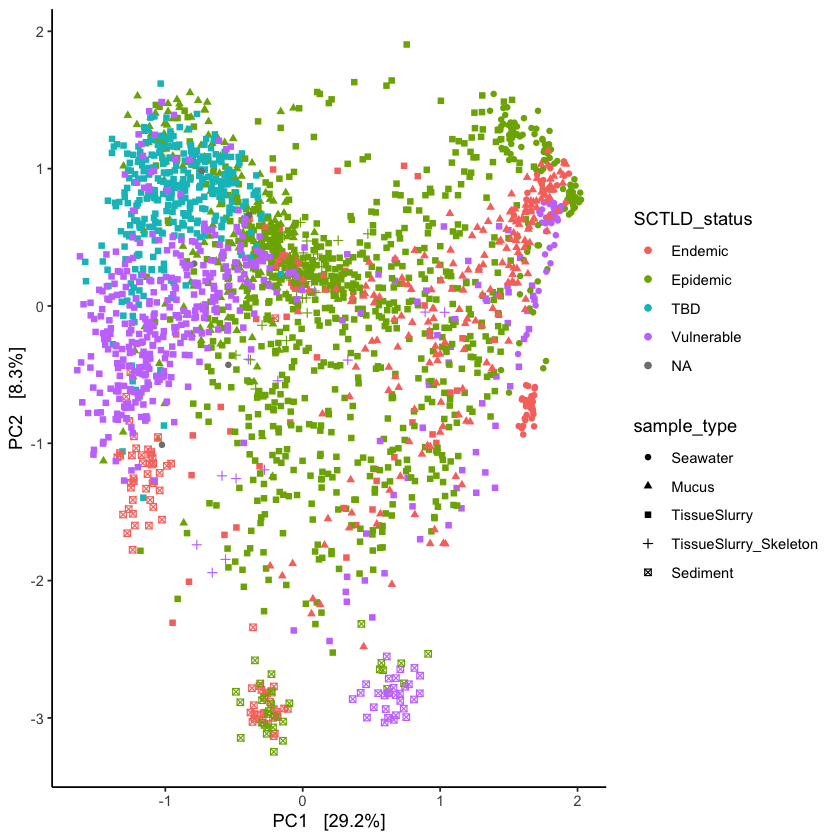

In [18]:
ord_zone = plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="SCTLD_status",
                               shape="sample_type",
                               axes = c(1,2)) +
theme_classic()

ord_zone

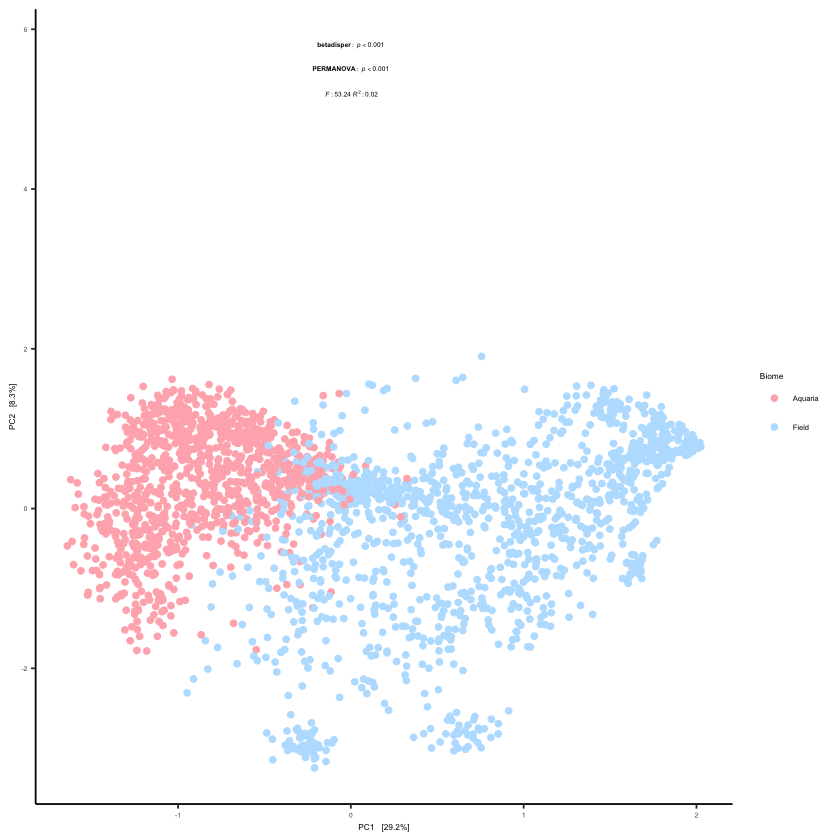

In [134]:
ord_biome = plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="Biome",
                              # shape="sample_type",
                            
                               axes = c(1,2)) +
theme_classic() +
scale_color_manual(values=c("#ffb3ba", "#bae1ff")) +
scale_shape_manual(values=c(1, 4, 5, 8, 9),
                  label=c(Mucus="Mucus\n",
                          Seawater="Seawater\n",
                          Sediment="Sediment\n",
                      TissueSlurry_Skeleton= "Tissue\nSlurry\nSkeleton",
                        TissueSlurry="Tissue\nSlurry")) +

theme(legend.text =element_text(size=4.5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =4)) +
theme(axis.text.y = element_text(size =4)) +
labs(shape='Sample type') +
annotate(geom="text", x=0, y=5.8,label = "bold(betadisper):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=-0, y=5.5,label = "bold(PERMANOVA):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=-0, y=5.2, label = "~italic(F):53.24~italic(R^2):0.02",
           parse = TRUE, 
      
              color="black", size=1.4) 



#stat_ellipse()
ord_biome

#	Df	SumOfSqs	R2	F	Pr(>F)
#<dbl>	<dbl>	<dbl>	<dbl>	<dbl>
#Biome	1	8.756918e+10	0.02295709	53.24308	0.001 

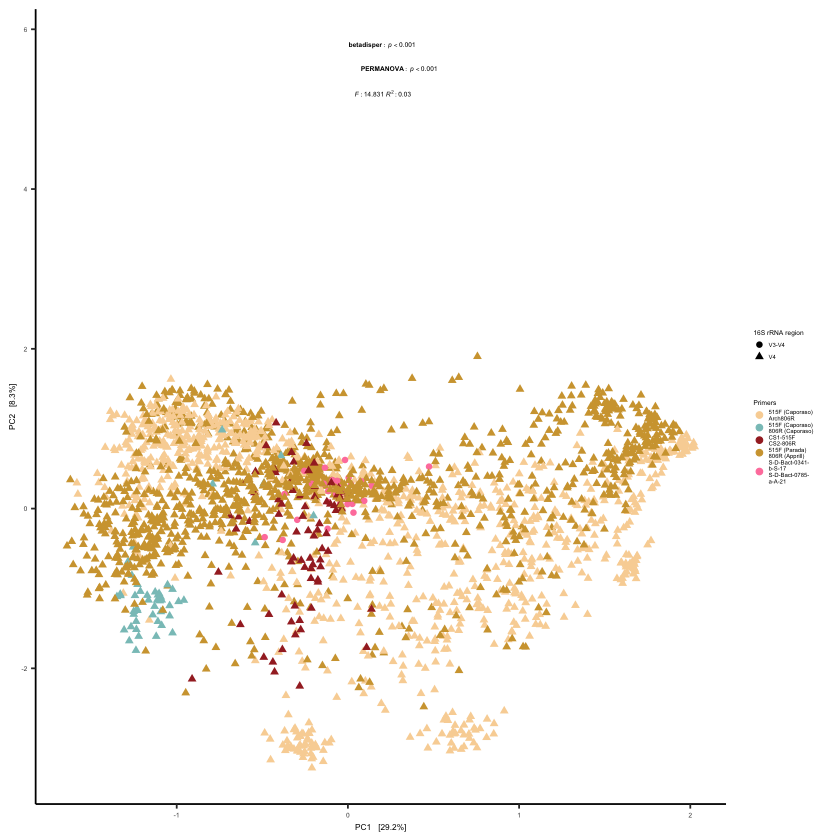

In [133]:





ord_primer= plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="primer_names",
                              shape="X16S_variable_region",
                               axes = c(1,2)) +


theme_classic() +


scale_color_manual(values=c("#F9D4A4", 
                            "#89C4C2",
                           "brown", 
                           "#D1A33D",
                            "palevioletred1",
                           "lightblue4"),
                  
                  labels=c(CS1_515F_CS2_806R="CS1-515F\nCS2-806R",
                         Pr515_806RAp="515F (Parada)\n806R (Apprill)",
                         S_D_Bact_0341_b_S_17_S_D_Bact_0785_a_A_21="S-D-Bact-0341-\nb-S-17\nS-D-Bact-0785-\na-A-21",
                        Caporaso515F_806RCaporaso="515F (Caporaso)\n806R (Caporaso)",
                          AA515F_archaea806R="515F (Caporaso)\nArch806R")) +
theme(legend.text =element_text(size=3.5)) +
theme(legend.title = element_text(size=4)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =4)) +
theme(axis.text.y = element_text(size =4)) +
theme(legend.key.size = unit(.5, 'lines')) +
labs(color='Primers', shape='16S rRNA region') +
annotate(geom="text", x=0.2, y=5.8,label = "bold(betadisper):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=0.3, y=5.5,label = "bold(PERMANOVA):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=0.2, y=5.2, label = "~italic(F):14.831~italic(R^2):0.03",
           parse = TRUE, 
      
              color="black", size=1.4) 

ord_primer



  
#Df	SumOfSqs	R2	F	Pr(>F)
#primer_names	4	9.744277e+10	0.02554555	14.83127	0.001

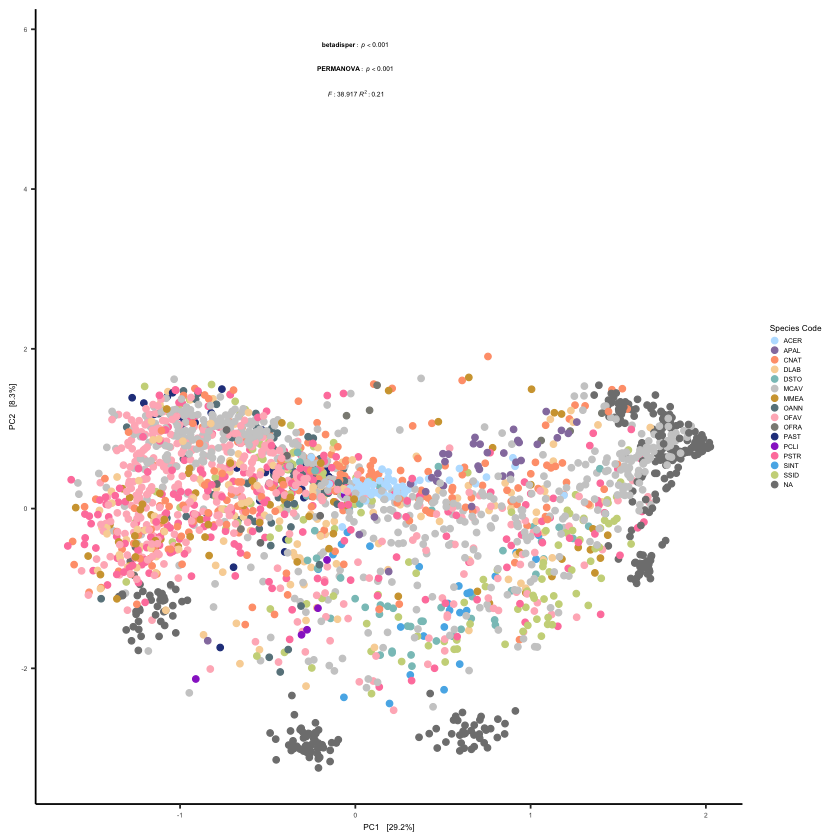

In [136]:
ord_species=plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="species_code",
                               axes = c(1,2)) +
theme_classic() +
scale_color_manual(values=c("#bae1ff", "#957DAD", "lightsalmon",  
                           
                           "#F9D4A4", 
                            "#89C4C2",
                        
                           "gray80", 
                           "#D1A33D",
                           "lightblue4", "lightpink", "ivory4","royalblue4", "darkorchid", 
                           "palevioletred1", "#56B4E9","#CBD588","yellow2","#5F7FC7", "orange","#DA5724",
                            "gray80",
                           "#AD6F3B", "#673770")) +


theme(legend.text =element_text(size=4)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =4)) +
theme(axis.text.y = element_text(size =4)) +
 theme(legend.key.size = unit(.4, 'lines')) +
labs(color='Species Code') +
annotate(geom="text", x=-0, y=5.8,label = "bold(betadisper):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=-0, y=5.5,label = "bold(PERMANOVA):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=-0, y=5.2, label = "~italic(F):38.917~italic(R^2):0.21",
           parse = TRUE, 
      
              color="black", size=1.4) 

ord_species


   
#species_code   14   1205288   86092  14.566 0.09186  0.001 ***
#Residuals    2016  11915809    5911         0.90814  

#Df	SumOfSqs	R2	F	Pr(>F)
#species_code	14	1.626312e+12	0.2127558	38.91656	0.00

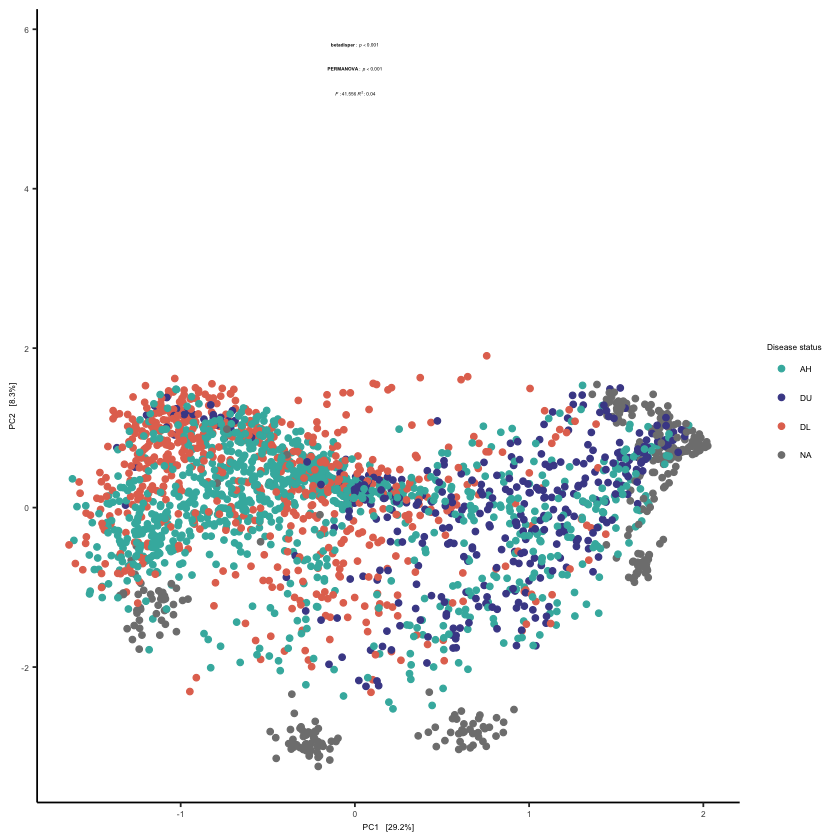

In [84]:

ord_tissue=plot_ordination(ps.coral_clr, ps.coral_clr.ord,

                               color="tissue_type",
                               axes = c(1,2)) +
theme_classic() +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =5)) +
theme(axis.text.y = element_text(size =5)) +
scale_color_manual(values=c("#40B5AD", "#4a4a96", "#E3735E")) +
labs(color='Disease status') +
annotate(geom="text", x=-0, y=5.8,label = "bold(betadisper):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.2) +

annotate(geom="text", x=-0, y=5.5,label = "bold(PERMANOVA):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.2) +

annotate(geom="text", x=-0, y=5.2, label = "~italic(F):41.556~italic(R^2):0.04",
           parse = TRUE, 
      
              color="black", size=1.2) 


ord_tissue

#Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
#tissue_type    2    516556  258278  41.556 0.03937  0.001 ***

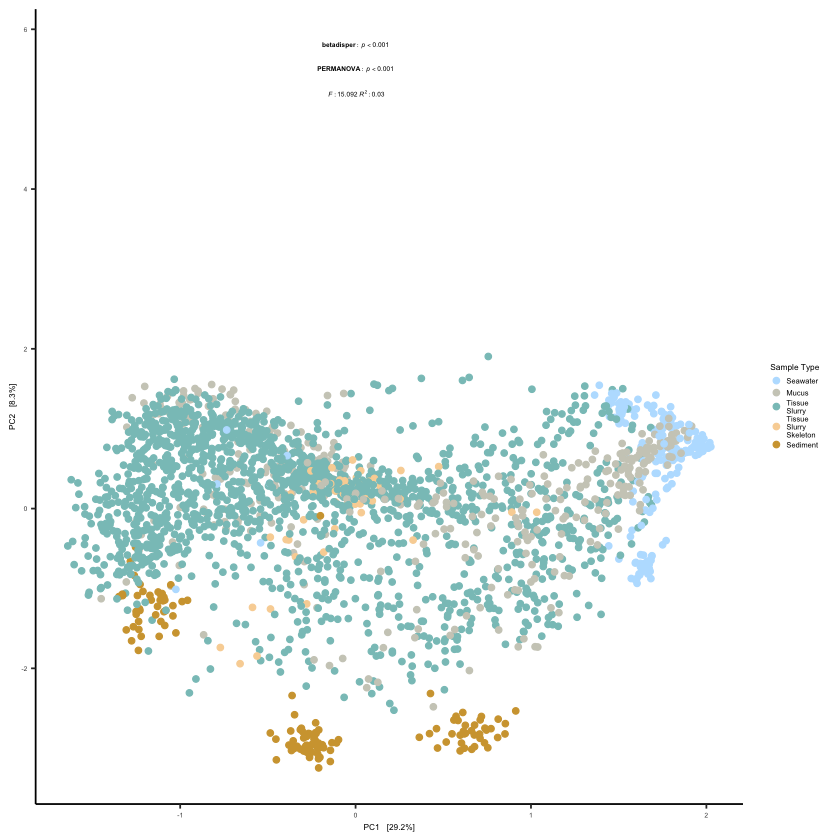

In [131]:
ord_type= plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="sample_type",
                               axes = c(1,2)) +
theme_classic() +
theme(legend.text =element_text(size=4.5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =4)) +
theme(axis.text.y = element_text(size =4)) +
theme(legend.key.size = unit(.5, 'lines')) +
labs(color='Sample Type') +

scale_color_manual(values=c("#bae1ff","ivory3", "#89C4C2",  "#F9D4A4" , "#D1A33D"), 
                  label=c(TissueSlurry_Skeleton= "Tissue\nSlurry\nSkeleton",
                        TissueSlurry= "Tissue\nSlurry" )) +
annotate(geom="text", x=-0, y=5.8,label = "bold(betadisper):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=-0, y=5.5,label = "bold(PERMANOVA):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=-0, y=5.2, label = "~italic(F):15.092~italic(R^2):0.03",
           parse = TRUE, 
      
              color="black", size=1.4) 

ord_type



#Df	SumOfSqs	R2	F	Pr(>F)
#sample_type	4	9.911154e+10	0.02598303	15.09204	0.001

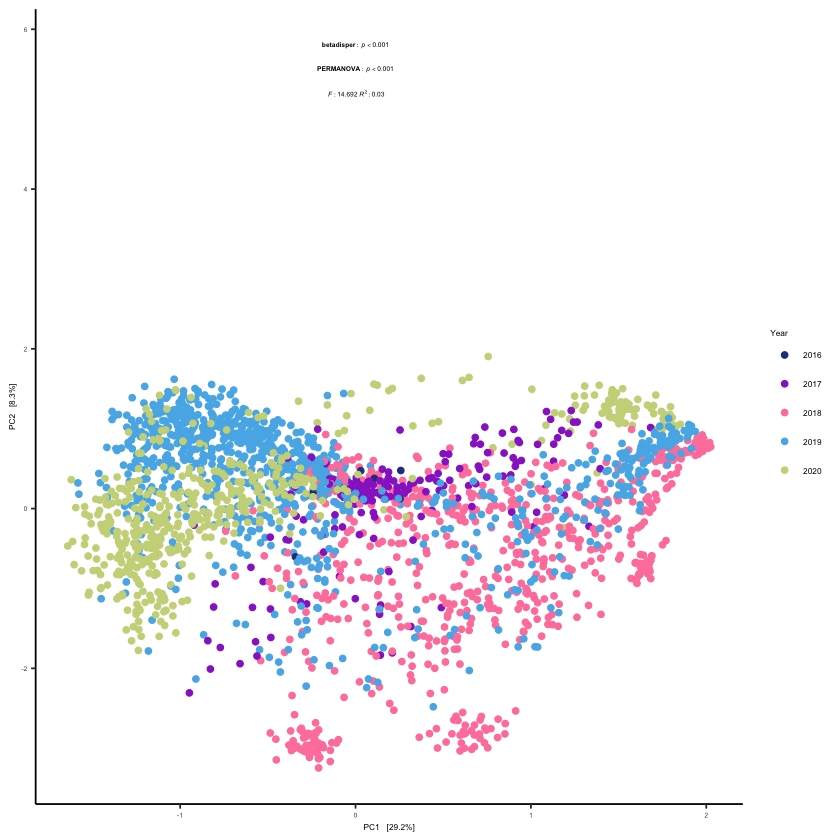

In [130]:
ord_year = plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="collection_year",
                               axes = c(1,2)) +
theme_classic() +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=5)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =4)) +
theme(axis.text.y = element_text(size =4)) +
labs(color='Year') +
annotate(geom="text", x=-0, y=5.8,label = "bold(betadisper):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=-0, y=5.5,label = "bold(PERMANOVA):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=-0, y=5.2, label = "~italic(F):14.692~italic(R^2):0.03",
           parse = TRUE, 
      
              color="black", size=1.4) +

scale_color_manual(values=c("royalblue4", "darkorchid", 
                           "palevioletred1", "#56B4E9","#CBD588","yellow2","#5F7FC7", "orange","#DA5724",
                            "gray80",
                           "#AD6F3B", "#673770"))

ord_year



 #  Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
#collection_year    4   2042202  510551  76.141 0.11443  0.001 ***

#Df	SumOfSqs	R2	F	Pr(>F)
#collection_year	4	9.654891e+10	0.02531122	14.69169	0.001

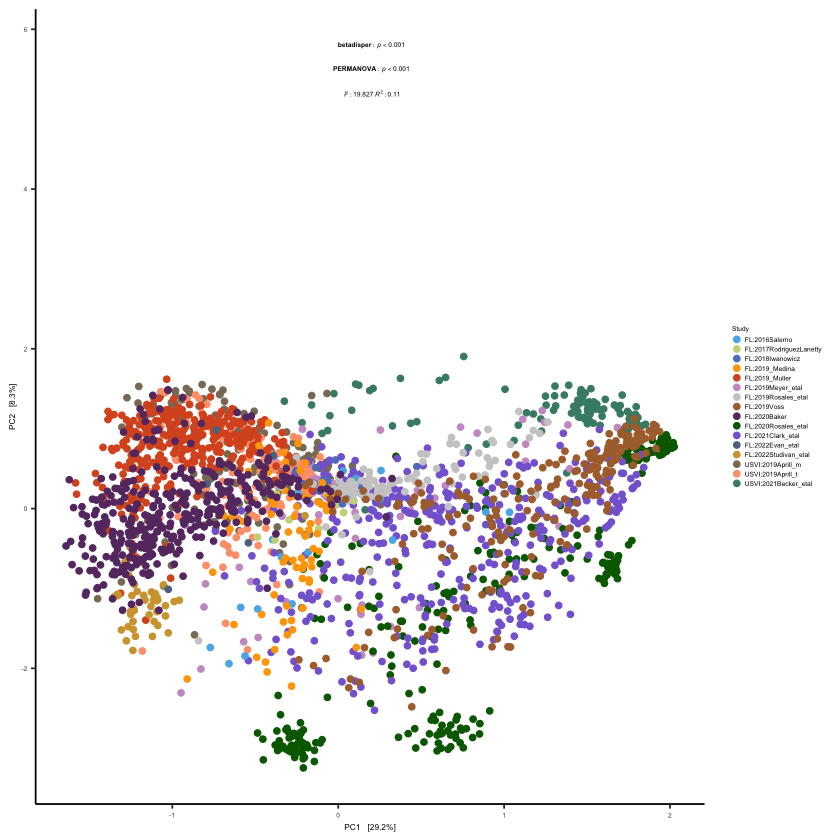

In [138]:
ord_alias= plot_ordination(ps.coral_clr, ps.coral_clr.ord,
                               color="Study",
                               axes = c(1,2)) +

theme_classic() +
theme(legend.text =element_text(size=4)) +
theme(legend.title = element_text(size=4)) +
theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 5)) +
theme(axis.text.x = element_text(size =4)) +
theme(axis.text.y = element_text(size =4)) +
 theme(legend.key.size = unit(.4, 'lines')) +
labs(color='Study') +
annotate(geom="text", x=0.2, y=5.8,label = "bold(betadisper):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=0.2, y=5.5,label = "bold(PERMANOVA):~italic(p)<0.001",
           parse = TRUE, 
      
              color="black", size=1.4) +

annotate(geom="text", x=0.2, y=5.2, label = "~italic(F):19.827~italic(R^2):0.11",
           parse = TRUE, 
      
              color="black", size=1.4) +

scale_color_manual(values=c("#56B4E9","#CBD588","#5F7FC7", "orange","#DA5724","#CD9BCD",
                           "gray80", "#AD6F3B", "#673770","#006700","#8569D5", 
                           "#5E738F","#D1A33D", "#8A7C64","lightsalmon","aquamarine4", "#652926",
                           "lightblue4", "lightpink","royalblue4","#D14285",
                           "palevioletred1", "#ffb3ba", "#bae1ff", "#957DAD", "lightsalmon",  
                           
                           "#F9D4A4", 
                            "#89C4C2",
                        
                           "gray80", 
                           "#D1A33D",
                           "lightblue4", "lightpink", "ivory4","royalblue4", "darkorchid", 
                           "palevioletred1", "#56B4E9","#CBD588","yellow2","#5F7FC7", "orange","#DA5724",
                            "gray80",
                           "#AD6F3B", "#673770"))

ord_alias

 #           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
#Study       15   5268467  351231   65.51 0.29521  0.001 
#Df	SumOfSqs	R2	F	Pr(>F)

#Alias	14	4.183989e+11	0.1096873	19.82653	0.001

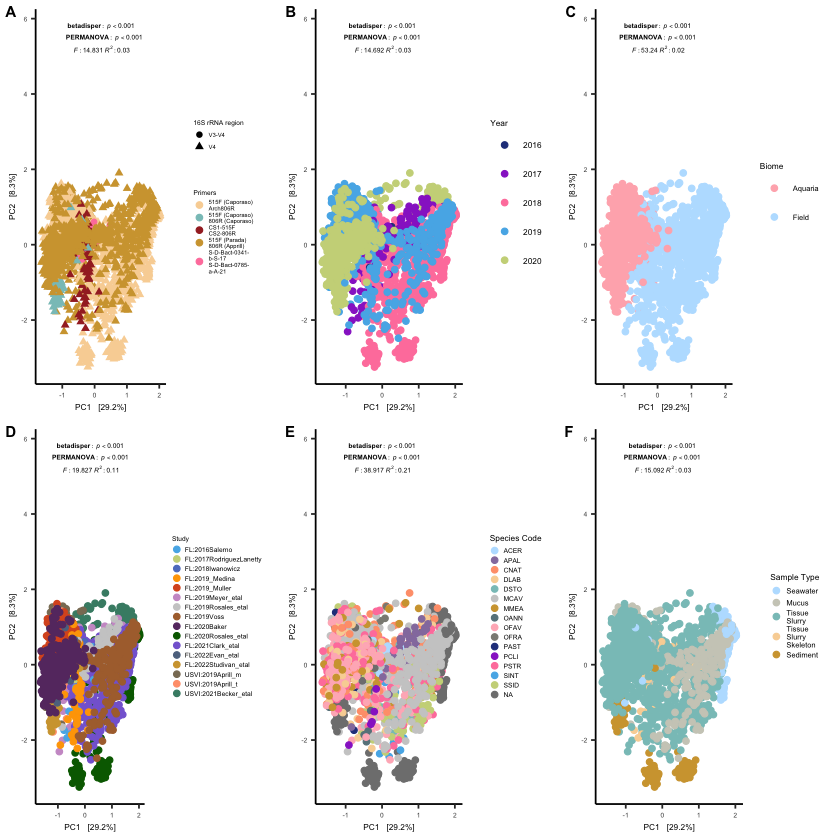

In [139]:
ggpubr::ggarrange(ord_primer, ord_year, ord_biome,
                 ord_alias, ord_species, ord_type,
                  labels = c("A", "B", "C", "D","E", "F"
                             #,"G"
                 )
                , font.label = list(size = 9, color = "black"))
ggsave("/Users/stephanie.rosales/Documents/Tissueloss/SCTLD_MetaAnalysis/figs/ord_AcerSedSea.png",
     width = 6.6, height = 4.5, units = "in", dpi=300)